# PROJECT FAME

**Problem**: Forecasting from early time well production leads to non-unique estimates of ultimate reserves. The production history required to qualify a forecast as confident is loosely defined.

**Hypthesis**: An accuracy score be used to relate the volume of production history to forecast confidence under different sets of conditions.

# WORK PLAN

1. Create synthetic forecasts
    - Exponential decline
    - Arps b=0.5, b~1.0, b=1.5
    - Irregular production case

2. Test different volume sampling periods
    - Daily data
    - Monthly data

3. Add error to the forecast
    - Zero error
    - Low error (how TBD)
    - Medium error
    - High error

4. At different time horizons ...
    - Bootstrap 100 realizations of the prior production history
        - *complication*: production history broadly declines as the result of withdraw, the window size for each boostrapped sample will need to be small or some bias needs to be introduced on the boostrap.
    - For each boostrap, regress an ARPs decline and calculate EUR from the
       forecast.
    - Caclulate accuracy score

5. Summarize findings.

Notes:
- From examples of real production data, production noise can be modeled with a
    - Laplace Distribition
    - Mean ~ 0
    - STD [10-40]

# EXAMPLE OF ONE ITERATION

In [179]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import seaborn as sns
import pickle
from scipy.optimize import minimize
from scipy.stats import gennorm
from matplotlib.ticker import StrMethodFormatter
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore', category=UserWarning)

golden_ratio = (1 + np.sqrt(5)) / 2

In [180]:
class ground_truth:
    """
    Class to generate ground truth data for a given set of parameters.

    Parameters:
    qi: Initial production rate, bopd
    di: Initial decline rate, effective annual
    b: Decline exponent
    dmin: Minimum decline rate, effective annual
    qab: Abandonment rate, bopd
    scale: Time scale, 'month' or 'day'
    """
    def __init__(self, qi, di, b, dmin, qab, time_scale):
        self.qi = qi
        self.di = di
        self.b = b
        self.dmin = dmin
        self.qab = qab
        self.time_scale = time_scale
        self.time_scalar = 365 if time_scale == 'day' else 12
        self.t = np.arange(0, 100 * self.time_scalar, 1)
        self.rate = self._calc_modified_arps(qi=self.qi, di=self.di, b=self.b, dmin=self.dmin, qab=self.qab)
        self.cum = np.cumsum(self.rate)
        self.eur = np.max(self.cum)
        self.quantiles = list(range(1, 100, 1))
    
    def _calc_modified_arps(self, qi=None, di=None, b=None, dmin=None, qab=None):
        """
        Calculate a modified ARPS decline with a terminal exponential 
        decline and an abandonment rate.
        
        Parameters:
        - qi: Initial production rate, bopd
        - di: Initial decline rate, effecitve annual
        - b: b-factor
        - dmin: Minimum decline rate, effective annual
        - r_abandon: Abandonment rate, bopd
        
        Returns:
        - Production rate at time t
        """
        t = self.t
        D_tangent = ((1 - di) ** (-b) - 1) / b
        D_terminal = -1 * np.log(1 - dmin)
        q_terminal = qi * (D_terminal / D_tangent) ** (1 / b)
        t_terminal = ((qi / q_terminal) ** b - 1) / (b * D_tangent / self.time_scalar)

        x = np.zeros(len(t))
        mask = t < t_terminal
        x[mask] = qi * (1 + b * (D_tangent / self.time_scalar) * t[mask]) ** (-1 / b)
        x[~mask] = q_terminal * np.exp(-1 * (D_terminal / self.time_scalar) * (t[~mask] - t_terminal))
        x[x < qab] = 0

        return x

    def _calculate_error_array(self, beta, loc, scale):
        """
        Caclulate an arrate with error and return it.
        """
        error = gennorm.rvs(beta=beta, loc=loc, scale=scale, size=len(self.rate))
        clipped_error = np.where((error < -1) | (error > 1), 0, error)
        return self.rate * (1 + clipped_error)

    def add_error(self, beta, loc, scale):
        """
        Add normally distributed error to the production rate.
        
        Parameters:
        - beta: Shape parameter for the generalized normal distribution
        - loc: Location parameter for the generalized normal distribution
        - scale: Scale parameter for the generalized normal distribution
                equivalent to the standard deviation

        Returns:
        - rate_error: Production rate with error
        """
        self.rate_error = self._calculate_error_array(beta=beta, loc=loc, scale=scale)
        self.rate_error = np.where(self.rate_error < 0, self.rate, self.rate_error)
        self.cum_error = np.cumsum(self.rate_error)
        self.eur_error = np.max(self.cum_error)

    def bootstrap(self, iterations, beta, loc, scale):
        """
        Simulate multiple realizatsion for the production rate with error.
        
        Parameters:
        - iterations: Number of bootstrap iterations to perform

        Returns:
        - bootstrap_array: Array of bootstrapped production rates
                        [iterations, len(self.rate)]
        """
        bootstrap_array = np.zeros(shape=(iterations, len(self.rate_error)))
        for i in range(iterations):
            bootstrap_array[i, :] = self._calculate_error_array(beta=beta, loc=loc, scale=scale)
        self.bootstrap_array = bootstrap_array


    def _regress_forecast(self, params, history):
        """
        Calculate forecasts and return MSE for the minimizer.
        
        Paramters:
        - params: List of parameters to optimize

        Returns:
        - mse: Mean squared error between the forecast and the history
        """
        di, b = params
        forecast = self._calc_modified_arps(qi=self.qi, di=di, b=b, dmin=self.dmin, qab=self.qab)
        mse = np.sum((forecast[:len(history)] - history) ** 2)
        return mse

    
    def calc_bootsrap_forecasts(self, time_increments, max_windows, initial, bounds):
        """
        Calculate forecasts for each bootstrap iteration using an expanding
        window the size of the time increments.

        Parameters:
        - time_increments: Size of the expanding window
        - max_windows: Maximum number of expanding windows to calculate
        - initial: Initial guess for the minimizer [di, b]
        - bounds: [(di_min, di_max), (b_min, b_max))]

        Returns: Array of EURs for each bootstrap iteration and window_size.
                    [bootstrap_iterations, time_increments]
        """
        expanding_windows = np.arange(time_increments, (time_increments + 1) * max_windows, time_increments)
        iterations = self.bootstrap_array.shape[0]
        fcst_eur_array = np.zeros(shape=(iterations, len(expanding_windows)))
        for i in range(iterations):
            for j, w in enumerate(expanding_windows):
                history = self.bootstrap_array[i, :w]
                match_di, match_b = minimize(self._regress_forecast, 
                                             x0=initial, 
                                             args=(history), 
                                             bounds=bounds).x
                forecast = self._calc_modified_arps(qi=self.qi, di=match_di, b=match_b, dmin=self.dmin, qab=self.qab)
                eur = np.max(np.cumsum(forecast))
                fcst_eur_array[i, j] = eur
        self.fcst_eur_array = fcst_eur_array 

    def average_forecast_error_quantiles(self):
        """
        Calculate the forecast error for each bootstap and gather the 
        quantiles.

        Returns: Array of average percentage error at each quantile for 
                    each bootstrap iteration. 
                    [quantiles, time_increments]
                 
        """
        quantiles = self.quantiles
        pct_error_array = (self.fcst_eur_array - self.eur) / self.eur * 100
        quantile_array = np.percentile(pct_error_array, quantiles, axis=0)
        self.avg_fcst_error_quantiles = quantile_array




In [181]:
# create a test instance of the well object and add error to the production rate
test = ground_truth(1000, 0.82, 1.2, 0.07, 1, 'day')
test.add_error(beta=0.5, loc=0, scale=0.05)  # beta=0.5, loc=0, scale=0.05

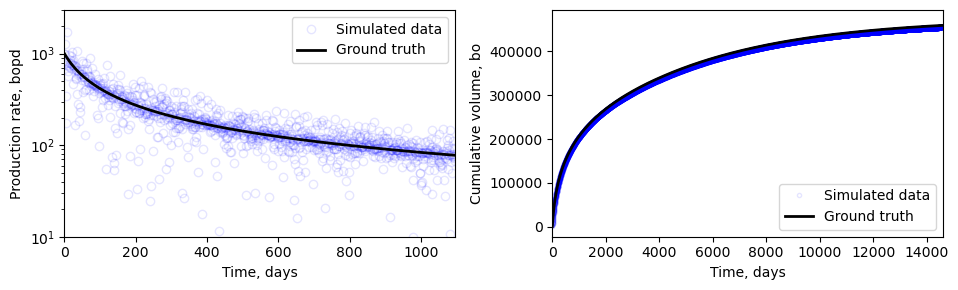

In [182]:
# plot the production rate and cumulative production with error for the test instance
fig, axs = plt.subplots(ncols=2, figsize=(golden_ratio * 3 * 2, 3))
axs[0].plot(test.t, test.rate_error, 'o', c='none', mec='b', alpha=0.10, label='Simulated data')
axs[0].plot(test.t, test.rate, 'k-', label='Ground truth', lw=2)
axs[0].set(xlabel='Time, days', ylabel='Production rate, bopd', yscale='log', xlim=(0,365 * 3), ylim=(10, 3000))
axs[0].legend(loc='upper right')
axs[1].plot(test.t, test.cum_error, '.', c='none', mec='b', alpha=0.10, label='Simulated data')
axs[1].plot(test.t, test.cum, 'k-', label='Ground truth', lw=2)
axs[1].set(xlabel='Time, days', ylabel='Cumulative volume, bo', xlim=(0,365*40))
axs[1].legend(loc='lower right')
plt.tight_layout(); plt.show()

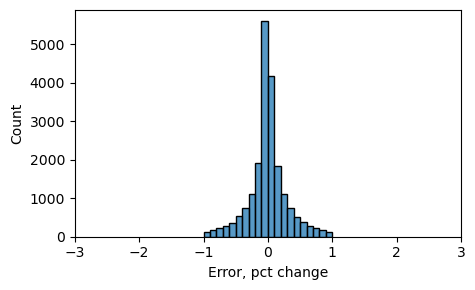

In [183]:
fig, ax = plt.subplots(figsize=(golden_ratio * 3, 3))
mask = test.rate > 0
sns.histplot((test.rate_error[mask] - test.rate[mask]) / test.rate[mask], ax=ax, binwidth=.1)
ax.set(xlabel='Error, pct change', ylabel='Count', xlim=(-3, 3))
plt.tight_layout(); plt.show()

In [184]:
# create the bootstrap array for the test instance
test.bootstrap(iterations=100, 
               beta=0.5, loc=0, scale=0.05)

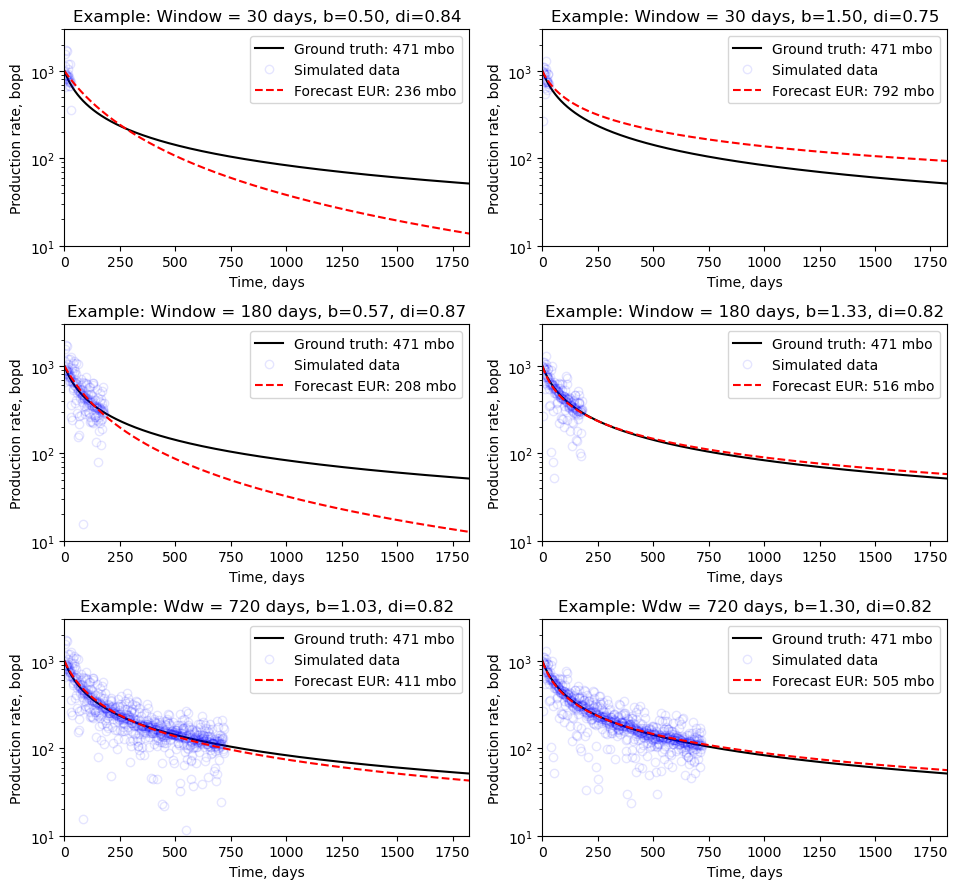

In [185]:
# create some forecast visuals
def calculate_single_bootsrap_fit(boot_strap_iteration, window_max, initial, bounds):
    history = test.bootstrap_array[boot_strap_iteration, :window_max]
    match_di, match_b = minimize(test._regress_forecast, 
                                    x0=initial, 
                                    args=(history), 
                                    bounds=bounds).x
    forecast = test._calc_modified_arps(qi=test.qi, di=match_di, b=match_b, dmin=test.dmin, qab=test.qab)
    return forecast, match_di, match_b

boot_strap_iteration = [5,10]
bounds = [(0.5, 0.99), (0.5, 1.5)]
initial_guess = [0.75, 1.001]

# plot the examples
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(2 * golden_ratio * 3, 3 * 3))
for i, bs in enumerate(boot_strap_iteration):
    window_1 = 30
    forecast_1, match_di_1, match_b_1 = calculate_single_bootsrap_fit(bs, window_1, initial_guess, bounds)
    axs[0, i].plot(test.t, test.rate, 'k-', label=f'Ground truth: {test.eur/1000:.0f} mbo')
    axs[0, i].plot(range(0,window_1), test.bootstrap_array[bs, :window_1], 
                'o', c='none', mec='b', alpha=0.1, label='Simulated data')
    axs[0, i].plot(test.t, forecast_1, 'r--', label=f'Forecast EUR: {np.max(np.cumsum(forecast_1))/1000:.0f} mbo')
    axs[0, i].set(xlabel='Time, days', ylabel='Production rate, bopd', yscale='log', xlim=(0,365 * 5), ylim=(10, 3000),
            title=f'Example: Window = 30 days, b={match_b_1:.2f}, di={match_di_1:.2f}')
    axs[0, i].legend(loc='upper right')

    window_2 = 180
    forecast_2, match_di_2, match_b_2 = calculate_single_bootsrap_fit(bs, window_2, initial_guess, bounds)
    axs[1, i].plot(test.t, test.rate, 'k-', label=f'Ground truth: {test.eur/1000:.0f} mbo')
    axs[1, i].plot(range(0,window_2), test.bootstrap_array[bs, :window_2], 
                'o', c='none', mec='b', alpha=0.1, label='Simulated data')
    axs[1, i].plot(test.t, forecast_2, 'r--', label=f'Forecast EUR: {np.max(np.cumsum(forecast_2))/1000:.0f} mbo')
    axs[1, i].set(xlabel='Time, days', ylabel='Production rate, bopd', yscale='log', xlim=(0,365 * 5), ylim=(10, 3000),
            title=f'Example: Window = 180 days, b={match_b_2:.2f}, di={match_di_2:.2f}')
    axs[1, i].legend(loc='upper right')

    window_3 = 720
    forecast_3, match_di_3, match_b_3 = calculate_single_bootsrap_fit(bs, window_3, initial_guess, bounds)
    axs[2, i].plot(test.t, test.rate, 'k-', label=f'Ground truth: {test.eur/1000:.0f} mbo')
    axs[2, i].plot(range(0,window_3), test.bootstrap_array[bs, :window_3], 
                'o', c='none', mec='b', alpha=0.1, label='Simulated data')
    axs[2, i].plot(test.t, forecast_3, 'r--', label=f'Forecast EUR: {np.max(np.cumsum(forecast_3))/1000:.0f} mbo')
    axs[2, i].set(xlabel='Time, days', ylabel='Production rate, bopd', yscale='log', xlim=(0,365 * 5), ylim=(10, 3000),
            title=f'Example: Wdw = 720 days, b={match_b_3:.2f}, di={match_di_3:.2f}')
    axs[2, i].legend(loc='upper right')

plt.tight_layout(); plt.show() 

In [186]:
# calculate forecasts for bootstrap iterations and different expanding windows
test.calc_bootsrap_forecasts(time_increments=60,
                             max_windows=22,
                             initial=[0.75, 1.0001],
                             bounds=[(0.5, 0.99), (0.5, 1.5)])

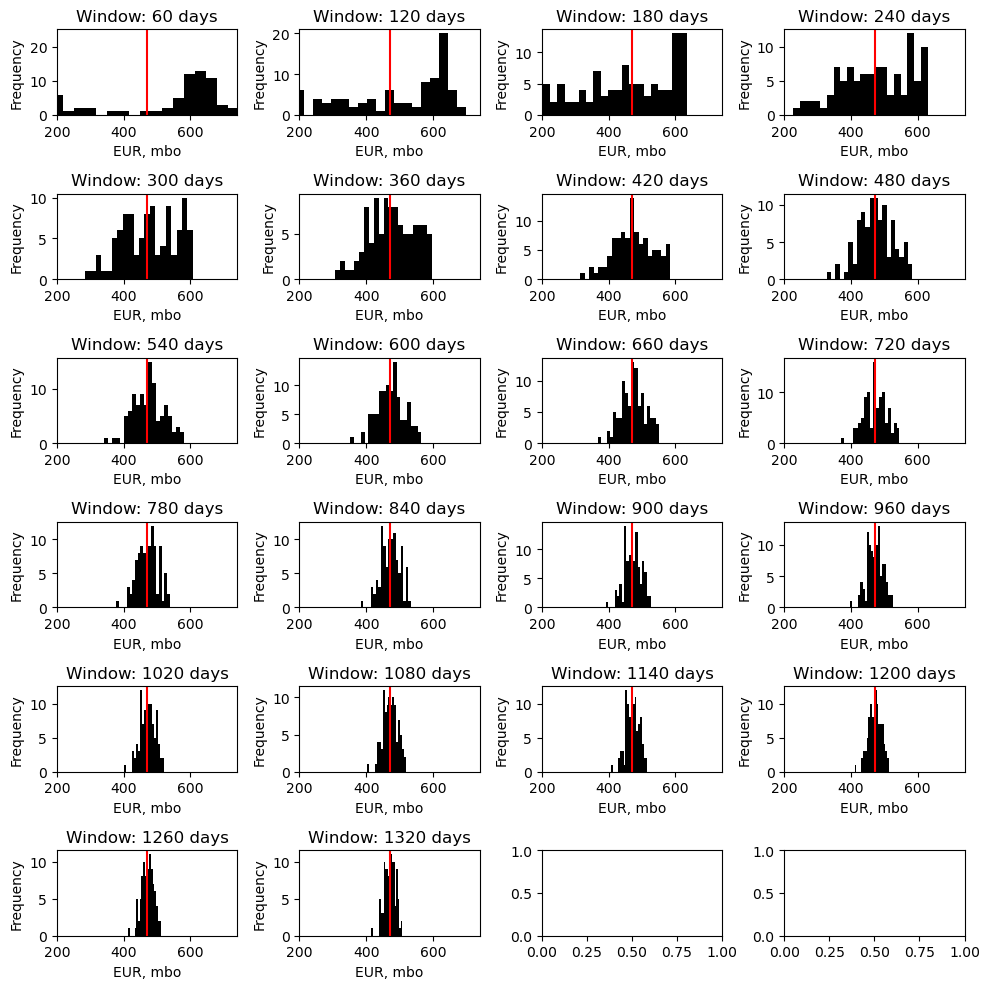

In [187]:
# create histrograms of bootstrapped forecasts for each time window of the test instance
fig, ax = plt.subplots(ncols=4, nrows=6, figsize=(10, 10))
for i in range(0, test.fcst_eur_array.shape[1]):
    ax[i // 4, i % 4].hist(test.fcst_eur_array[:, i]/1000, bins=20, color='k')
    ax[i // 4, i % 4].axvline(test.eur/1000, c='r', label='Ground truth')
    ax[i // 4, i % 4].set(xlim=(200,740), title=f'Window: {i * 60 + 60} days', xlabel='EUR, mbo', ylabel='Frequency')

    plt.tight_layout()
plt.tight_layout(); plt.show()

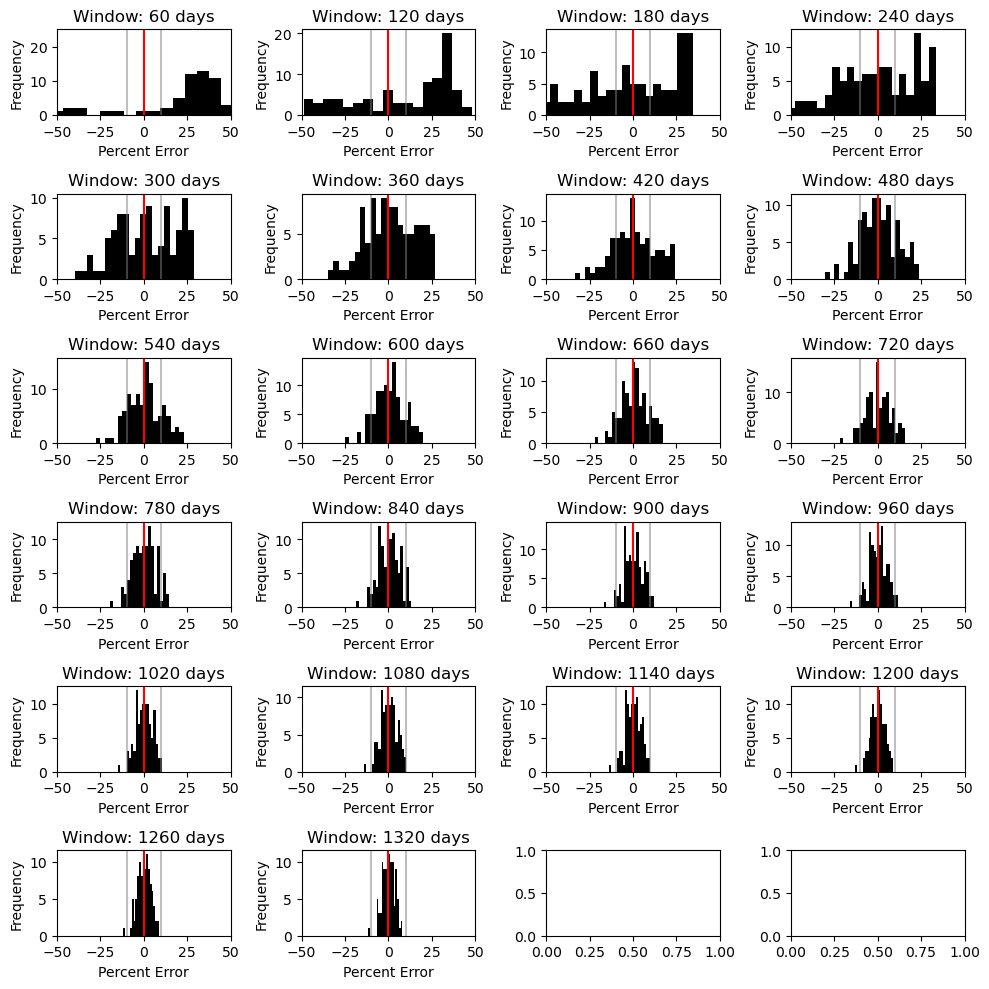

In [188]:
# create histrograms of bootstrapped forecasts for each time window of the test instance
fig, ax = plt.subplots(ncols=4, nrows=6, figsize=(10, 10))
for i in range(0, test.fcst_eur_array.shape[1]):
    ax[i // 4, i % 4].hist((test.fcst_eur_array[:, i] - test.eur) / test.eur * 100, bins=20, color='k')
    ax[i // 4, i % 4].axvline(0, c='r', label='Ground truth')
    ax[i // 4, i % 4].axvline(10, c='gray', alpha=0.5, label='Ground truth')
    ax[i // 4, i % 4].axvline(-10, c='gray', alpha=0.5, label='Ground truth')
    ax[i // 4, i % 4].set(xlim=(-50,50), title=f'Window: {i * 60 + 60} days', xlabel='Percent Error', ylabel='Frequency')

    plt.tight_layout()
plt.tight_layout(); plt.show()

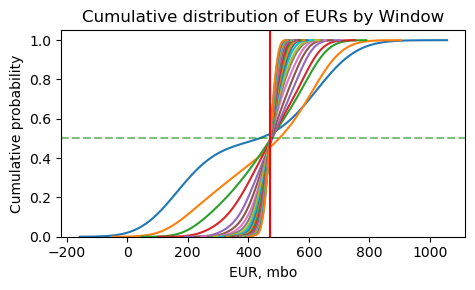

In [189]:
# look at the cdf of the bootstrapped forecasts
fig, ax = plt.subplots(figsize=(golden_ratio * 3, 3))
for i in range(0, test.fcst_eur_array.shape[1]):
    sns.kdeplot(test.fcst_eur_array[:, i]/1000, cumulative=True, ax=ax, label=f'Window: {i * 60 + 60} days')
ax.axvline(test.eur/1000, c='r', label='Ground truth')
ax.axhline(0.5, c='g', ls='--', alpha=0.5)
ax.set(xlabel='EUR, mbo', ylabel='Cumulative probability', title='Cumulative distribution of EURs by Window')
ax.legend().set_visible(False)
plt.tight_layout()
plt.show()

# Repeat the process across multiple well forecasts

In [190]:
# repeat the process for a range of different well forecasts

forecast_parameters = pd.read_excel('Forecast_Input_Parameters.xlsx')
forecast_parameters['eur'] = None
forecast_parameters['well_objects'] = None
forecast_parameters['score'] = None

beta = 0.5
loc = 0
scale = 0.05 
bootstrap_iterations = 100
bootstrap_window = 30
time_increment = 90
max_windows = 8
initial_guess = [0.75, 1.001]
bounds = [(0.5, 0.99), (0.5, 1.5)]
dmin = 0.07
qab = 1

quantile_array = list()
for i, row in tqdm(forecast_parameters.iterrows(), total=len(forecast_parameters)):
    well = ground_truth(row['qi'], row['di'], row['b'], dmin, qab, 'day')
    well.add_error(beta=beta, loc=loc, scale=scale)
    well.bootstrap(iterations=bootstrap_iterations, beta=beta, loc=loc, scale=scale)
    well.calc_bootsrap_forecasts(time_increments=time_increment, max_windows=max_windows, 
                                 initial=initial_guess, bounds=bounds)
    well.average_forecast_error_quantiles()
    forecast_parameters.loc[i, 'eur'] = well.eur
    forecast_parameters.loc[i, 'well_objects'] = well
    quantile_array.append(well.avg_fcst_error_quantiles)

quantile_array = np.stack(quantile_array) # [well_objects, confidence_intervals, time_increments]

# took 9m to run on my laptop

  0%|          | 0/100 [00:00<?, ?it/s]

In [191]:
# average the quantiles across the well objects for each time increment
# [confidence_intervals, time_increments]
avg_quantiles = np.mean(quantile_array, axis=0)


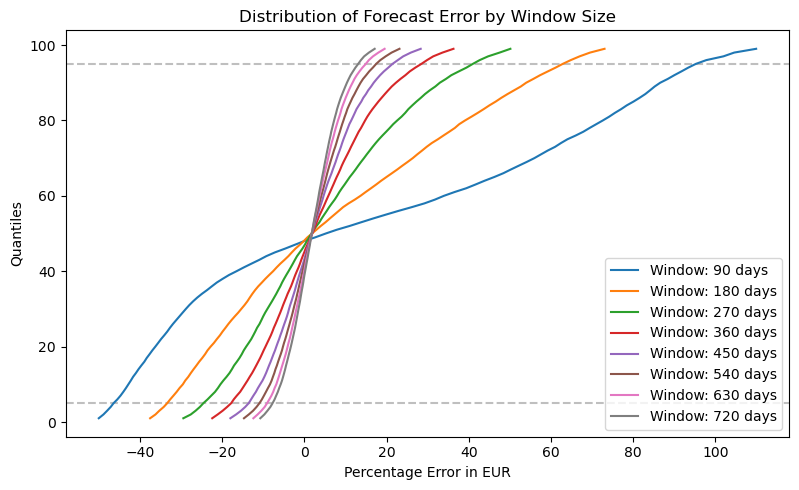

In [192]:
quantiles = forecast_parameters.iloc[0]['well_objects'].quantiles

fig, ax = plt.subplots(figsize=(golden_ratio * 5, 5))
ax.axhline(95, c='gray', ls='--', alpha=0.5)
ax.axhline(5, c='gray', ls='--', alpha=0.5)
for i in range(0, avg_quantiles.shape[1]):
    ax.plot(avg_quantiles[:, i], quantiles, 
            label=f'Window: {(i + 1) * time_increment} days')
ax.set(xlabel='Percentage Error in EUR', ylabel='Quantiles', 
       title='Distribution of Forecast Error by Window Size')
ax.legend(loc='lower right')
plt.tight_layout(); plt.show()


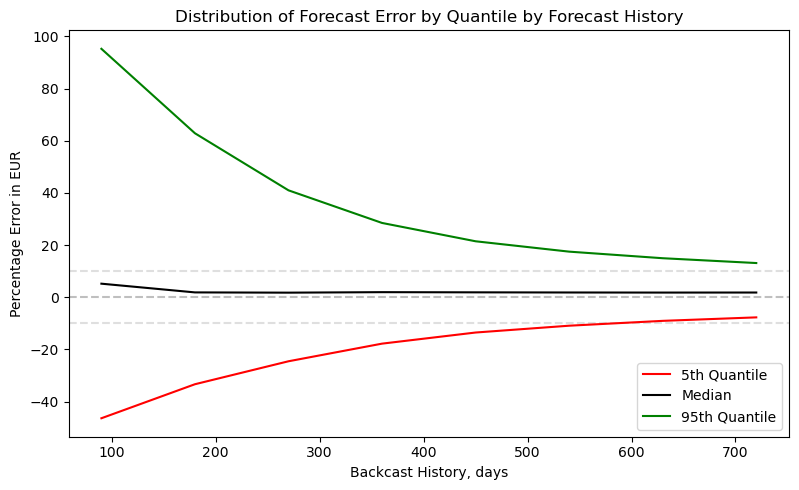

In [193]:
windows = range(time_increment, (time_increment + 1) * max_windows, time_increment)

fig, ax = plt.subplots(figsize=(golden_ratio * 5, 5))
ax.axhline(0, c='gray', ls='--', alpha=0.5)
ax.axhline(10, c='gray', ls='--', alpha=0.25)
ax.axhline(-10, c='gray', ls='--', alpha=0.25)
ax.plot(windows, avg_quantiles[4, :], 'r-', label='5th Quantile')
ax.plot(windows, avg_quantiles[49, :], 'k-', label='Median')
ax.plot(windows, avg_quantiles[94, :], 'g-', label='95th Quantile')
ax.set(xlabel='Backcast History, days', ylabel='Percentage Error in EUR', 
       title='Distribution of Forecast Error by Quantile by Forecast History')
ax.legend(loc='lower right')
plt.tight_layout(); plt.show()


# Repeat the entire process for different levels of production noise

In [194]:
# repeat the process for a range of different well forecasts

forecast_parameters = pd.read_excel('Forecast_Input_Parameters.xlsx')
forecast_parameters['eur'] = None
forecast_parameters['well_objects'] = None
forecast_parameters['score'] = None

beta = 0.5
loc = 0
scales = [0.001, 0.02, 0.05, 0.07, 0.1] 
bootstrap_iterations = 100
bootstrap_window = 30
time_increment = 90
max_windows = 8
initial_guess = [0.75, 1.001]
bounds = [(0.5, 0.99), (0.5, 1.5)]
dmin = 0.07
qab = 1

error_and_qunatile_array = list()
for s in tqdm(scales, total=len(scales)):
    quantile_array = list()
    for j, row in tqdm(forecast_parameters.iterrows(), total=len(forecast_parameters)):
        well = ground_truth(row['qi'], row['di'], row['b'], dmin, qab, 'day')
        well.add_error(beta=beta, loc=loc, scale=s)
        well.bootstrap(iterations=bootstrap_iterations, beta=beta, loc=loc, scale=s)
        well.calc_bootsrap_forecasts(time_increments=time_increment, max_windows=max_windows, 
                                     initial=initial_guess, bounds=bounds)
        well.average_forecast_error_quantiles()
        forecast_parameters.loc[j, 'eur'] = well.eur
        forecast_parameters.loc[j, 'well_objects'] = well
        quantile_array.append(well.avg_fcst_error_quantiles)

    quantile_array = np.stack(quantile_array)  # [well_objects, confidence_intervals, time_increments]
    error_and_qunatile_array.append(quantile_array)

error_and_qunatile_array = np.stack(error_and_qunatile_array)  
# [scales, well_objects, confidence_intervals, time_increments]

# took 99m to run on my laptop

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [195]:
error_and_qunatile_array.shape

(5, 100, 99, 8)

In [196]:
# pickle the Pandas DataFrame
with open('forecast_parameters.pkl', 'wb') as f:
    pickle.dump(forecast_parameters, f)

# pickle the Numpy errore and quantile array
with open('error_and_qunatile_array.pkl', 'wb') as f:
    pickle.dump(error_and_qunatile_array, f)

In [197]:
# [scales, qunatiles, time_increments]
average_quantiles_by_error = np.mean(error_and_qunatile_array, axis=1)

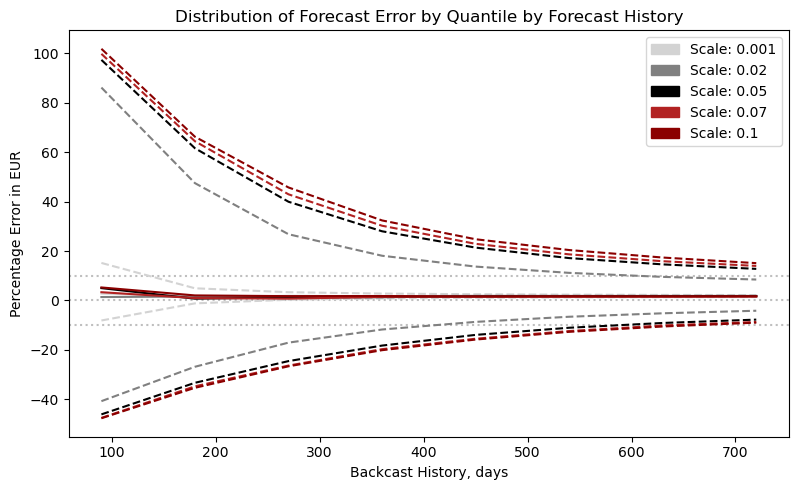

In [198]:
# map the 90th confidence interval for each error scale
col_map = {0: 'lightgray', 1: 'gray', 2: 'black', 3: 'firebrick', 4: 'darkred'}

fig, ax = plt.subplots(figsize=(golden_ratio * 5, 5))
ax.axhline(0, c='gray', ls=':', alpha=0.5)
ax.axhline(10, c='gray', ls=':', alpha=0.5)
ax.axhline(-10, c='gray', ls=':', alpha=0.5)
for i, scale in enumerate(scales):
       ax.plot(windows, average_quantiles_by_error[i, 4, :], c=col_map[i], ls='--')
       ax.plot(windows, average_quantiles_by_error[i, 49, :], c=col_map[i], ls='-')
       ax.plot(windows, average_quantiles_by_error[i, 94, :], c=col_map[i], ls='--')

ax.set(xlabel='Backcast History, days', ylabel='Percentage Error in EUR', 
          title='Distribution of Forecast Error by Quantile by Forecast History')

# Create custom legend
legend_patches = [mpatches.Patch(color=col_map[i], label=f'Scale: {scales[i]}') for i in range(len(scales))]
ax.legend(handles=legend_patches, loc='upper right')

plt.tight_layout()
plt.show()


/var/folders/s9/_cs16tjx7cx0fn7dssgglhbh0000gn/T/ipykernel_6436/1963356224.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('binary')


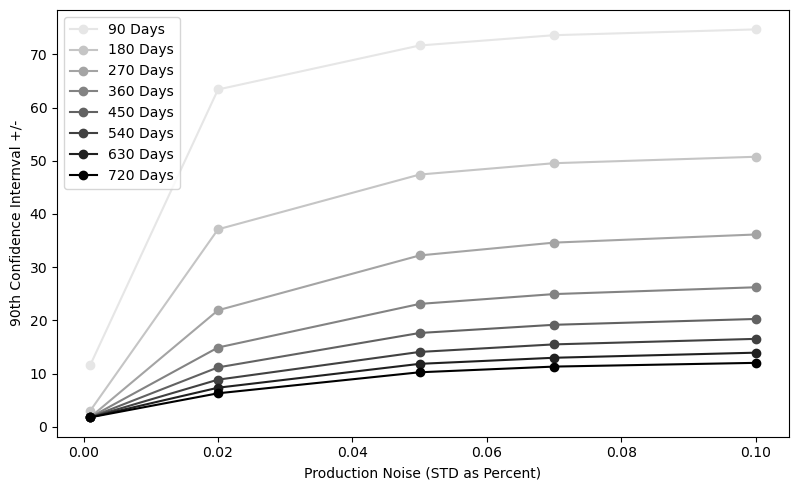

In [199]:
expanding_windows = range(time_increment, (time_increment + 1) * max_windows, time_increment)
cmap = cm.get_cmap('binary')
col_map = [cmap(i) for i in np.linspace(0.1, 1, len(expanding_windows))]

fig, ax = plt.subplots(figsize=(golden_ratio * 5, 5))
for i, window in enumerate(expanding_windows):
    ax.plot(scales, (average_quantiles_by_error[:, 94, i] + np.abs(average_quantiles_by_error[:, 4, i])) / 2, 
            'o-', c=col_map[i], label=f'{window} Days')
ax.set(xlabel='Production Noise (STD as Percent)', ylabel='90th Confidence Internval +/-')
ax.legend(loc='upper left')
plt.tight_layout(); plt.show()